## Amazon Food Reviews - Logistic Regression

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.preprocessing import normalize
from scipy.sparse import find
from scipy.sparse import csr_matrix
from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore") 

In [3]:
df= pd.read_csv("../../../../Desktop/Prep/ML_Repo/amazon-fine-food-reviews/Reviews.csv")
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df.shape

(568454, 10)

In [5]:
import pickle

def save_data(data,file):
    pickle.dump(data,open(file+".pkl","wb"))
    
def load_data(file):
    data = pickle.load(open(file+".pkl","rb"))
    return data

In [6]:
lr_data = load_data('../Amazon_Food_Review_KNN/150k_nb')
lr_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
346116,374422,B00004CI84,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,GREAT,THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...,one movi movi collect fill comedi action whate...
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",alway enjoy movi funni entertain didnt hesit p...


In [7]:
def confusion_matrix_plot(y_test,pred):
    df_bow = pd.DataFrame(confusion_matrix(y_test, pred))  
    sns.heatmap(df_bow, annot=True)
    tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
    print('True Positive',tp)
    print('True Negative',tn)
    print('False Positive',fp)
    print('False Negative',fn)

In [8]:
def metric_scores(y_test,pred):
    acc_scores = [[accuracy_score(y_test, pred)*100,precision_score(y_test,pred),recall_score(y_test,pred),f1_score(y_test,pred)]]
    acc_scores = pd.DataFrame(acc_scores,columns=['Accuracy','Precision score','Recall score','F1 score'])
    return acc_scores

In [9]:
def l1_vs_l2_accuracy_plot(a1):
    list1 = []
    for i in range(len(a1.cv_results_['params'])):
        list1.append(a1.cv_results_['params'][i]['C'])
        
    l1_arr = []
    l2_arr = []
    l1_acc = []
    l2_acc = []
    for i in range(len(list1)):
        if a1.cv_results_['params'][i]['penalty'] == 'l1':
            l1_arr.append(a1.cv_results_['params'][i])
            l1_acc.append(a1.cv_results_['mean_test_score'][i]*100)
        else:
            l2_arr.append(a1.cv_results_['params'][i]) 
            l2_acc.append(a1.cv_results_['mean_test_score'][i]*100)
    
    sns.set_style("whitegrid")
    plt.plot([i['C'] for i in l1_arr],l1_acc, label = 'L1')
    plt.plot([i['C'] for i in l2_arr],l2_acc, label = 'L2')
    plt.xlabel("L1 & L2 C Values")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs L1 & L2 C Values")
    plt.legend()
    plt.show()   

In [10]:
def sparsity_analysis(x_train,y_train):
    
    # List of C Values to be trained on
    c_list = [0.005,0.01,0.5,0.1,1,10,50,100,500,1000]
    c_max = 0
    c_min = 0
    for i in c_list:
        lr_optimal = LogisticRegression(C = i ,penalty = 'l1')
        lr_optimal.fit(x_train, y_train)
        
        # Calculating the no. of zero elements for each C value
        print('No. of zero elements for C = %0.3f is %d' %(i,lr_optimal.coef_[0].size - np.count_nonzero(lr_optimal.coef_[0])))
        
        # Calculating the no. of zero elements corresponding to min. and max. C value.
        if i == 0.005:
            c_min = lr_optimal.coef_[0].size - np.count_nonzero(lr_optimal.coef_[0])
        elif i == 1000:
            c_max = lr_optimal.coef_[0].size - np.count_nonzero(lr_optimal.coef_[0])
    
    #print('Percentage increase in Sparsity is %0.2f% %'%(((c_min-c_max)/c_max)*100))
    
    try:
        print('Percentage increase in Sparsity is %0.2f% %'%(((c_min-c_max)/c_max)*100))
    except ZeroDivisionError:
        print('Percentage increase in Sparsity is %0.2f% %'%(((c_min-c_max)/c_min)*100))

In [11]:
def multicollinearity_check(x_train,y_train,x_test,y_test,best_c,best_penalty):
    
    # To avoid changes in shape of old x_train and new_x_train due to sparsity
    if best_penalty == 'l1':
        best_penalty = 'l2'
    
    # Training the model with x_train and y_train
        
    lr_optimal_old = LogisticRegression(C = best_c ,penalty = best_penalty)
    lr_optimal_old.fit(x_train, y_train)
    pred_old = lr_optimal_old.predict(x_test)
    acc_old = accuracy_score(y_test, pred_old) * 100
    
    print('Accuracy before adding noise is ',acc_old)
    
    # Obtaining the weight coefficients of the trained model
    old_weights = find(lr_optimal_old.coef_[0])[2]
    
    # Generating random noise
    mu, sigma = 0, 10**-2 
    noise = np.random.normal(mu, sigma, size = x_train.size)
    
    # Finding out the indices of the non-zero pts. in x_train
    row,column,values = find(x_train)
    new_x_train = x_train
    
    # Adding noise to the new x_train at indices of non-zero pts.
    new_x_train[row,column] = noise + new_x_train[row,column]
    
    # Training the model with new x_train and y_train
    lr_optimal_new = LogisticRegression(C = best_c ,penalty = best_penalty)
    lr_optimal_new.fit(new_x_train, y_train)
    pred_new = lr_optimal_new.predict(x_test)
    acc_new = accuracy_score(y_test, pred_new) * 100
    
    print('Accuracy after adding noise is ',acc_new)

    # Obtaining the weight coefficients of the newly trained model
    new_weights = find(lr_optimal_new.coef_[0])[2]
    
    # Finding out the percentage difference in weights
    weight_changes = (abs((old_weights-new_weights)/old_weights))*100
    
    # Returning the no. of features which have weight changes greater than 70%
    
    return weight_changes[np.where(weight_changes>70)].size
    

In [12]:
def top_25_features(lr_optimal,vectorizer):
    
    zipped = zip(lr_optimal.coef_[0],vectorizer.get_feature_names())
    sorted_values = sorted(zipped, key=lambda x: x[0])
     
    a = []
    for i in range(25):
        b = []
        b.append(sorted_values[len(sorted_values)-26+i][0])
        b.append(sorted_values[len(sorted_values)-26+i][1])
        b.append(sorted_values[i][0])
        b.append(sorted_values[i][1])
        a.append(b)
        
    a1 = pd.DataFrame(a)
    a1.columns = ['Positive Values','Positive Words','Negative Values','Negative Words']
    return a1   

In [13]:
def summary_of_scores():
    x = PrettyTable()
    x.field_names = ["Model", "CV - Type", "Best C", "Best Penalty", "Best Accuracy"]
    x.add_row(["BOW","Grid Search",load_data('bow_grid_search_lr').best_params_.get('C'),load_data('bow_grid_search_lr').best_params_.get('penalty'),load_data('bow_grid_search_lr').best_score_*100])
    x.add_row(["BOW","Randomized Search", load_data('bow_grid_search_lr_rscv').best_params_.get('C'),load_data('bow_grid_search_lr_rscv').best_params_.get('penalty'),load_data('bow_grid_search_lr_rscv').best_score_*100])
    x.add_row(["Trigram","Grid Search", load_data('trigram_grid_search_lr').best_params_.get('C'),load_data('trigram_grid_search_lr').best_params_.get('penalty'),load_data('trigram_grid_search_lr').best_score_*100])
    x.add_row(["Trigram","Randomized Search", load_data('trigram_grid_search_lr_rscv').best_params_.get('C'),load_data('trigram_grid_search_lr_rscv').best_params_.get('penalty'),load_data('trigram_grid_search_lr_rscv').best_score_*100])
    x.add_row(["Tf-Idf","Grid Search", load_data('tfidf_grid_search_lr').best_params_.get('C'),load_data('tfidf_grid_search_lr').best_params_.get('penalty'),load_data('tfidf_grid_search_lr').best_score_*100])
    x.add_row(["Tf-Idf","Randomized Search", load_data('tfidf_grid_search_lr_rscv').best_params_.get('C'),load_data('tfidf_grid_search_lr_rscv').best_params_.get('penalty'),load_data('tfidf_grid_search_lr_rscv').best_score_*100])
    x.add_row(["W2V","Grid Search", load_data('w2v_grid_search_lr').best_params_.get('C'),load_data('w2v_grid_search_lr').best_params_.get('penalty'),load_data('w2v_grid_search_lr').best_score_*100])
    x.add_row(["W2V","Randomized Search", load_data('w2v_grid_search_lr_rscv').best_params_.get('C'),load_data('w2v_grid_search_lr_rscv').best_params_.get('penalty'),load_data('w2v_grid_search_lr_rscv').best_score_*100])
    x.add_row(["Tf-Idf - W2v","Grid Search", load_data('tfidf_w2v_grid_search_lr').best_params_.get('C'),load_data('tfidf_w2v_grid_search_lr').best_params_.get('penalty'),load_data('tfidf_w2v_grid_search_lr').best_score_*100])
    x.add_row(["Tf-Idf - W2v","Randomized Search", load_data('tfidf_w2v_grid_search_lr_rscv').best_params_.get('C'),load_data('tfidf_w2v_grid_search_lr_rscv').best_params_.get('penalty'),load_data('tfidf_w2v_grid_search_lr_rscv').best_score_*100])
    print(x)
    

### Bag Of Words -LR

### Best Hyperparameter C and Regularizer using GridSearchCV

In [26]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [27]:
from sklearn.preprocessing import Normalizer
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = count_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [29]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search = GridSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [30]:
save_data(grid_search,'bow_grid_search_lr')

In [31]:
a1 = load_data('bow_grid_search_lr')

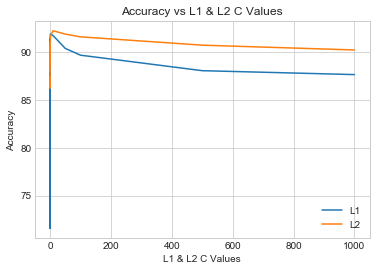

In [32]:
l1_vs_l2_accuracy_plot(a1)

In [33]:
print('Best Hyperparameter and Regularizer ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Hyperparameter and Regularizer  {'C': 10, 'penalty': 'l2'}
Best Accuracy 92.265143%


In [34]:
from sklearn.metrics import accuracy_score
lr_optimal = LogisticRegression(C = a1.best_params_.get('C'),penalty = a1.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [35]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,92.757778,0.943231,0.975058,0.958881


True Positive 37999
True Negative 3742
False Positive 2287
False Negative 972


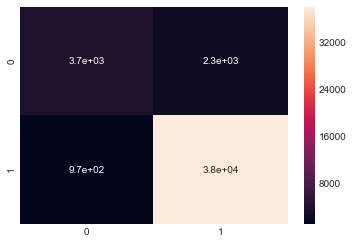

In [36]:
confusion_matrix_plot(y_test,pred)

### Sparsity Analysis

In [37]:
sparsity_analysis(x_train,y_train)

No. of zero elements for C = 0.005 is 47253
No. of zero elements for C = 0.010 is 47239
No. of zero elements for C = 0.500 is 46421
No. of zero elements for C = 0.100 is 46976
No. of zero elements for C = 1.000 is 45915
No. of zero elements for C = 10.000 is 40454
No. of zero elements for C = 50.000 is 34500
No. of zero elements for C = 100.000 is 32395
No. of zero elements for C = 500.000 is 28488
No. of zero elements for C = 1000.000 is 27135
Percentage increase in Sparsity is 74.14%


### Perturbation test

In [38]:
no_of_features = multicollinearity_check(x_train,y_train,x_test,y_test,a1.best_params_.get('C'),a1.best_params_.get('penalty'))

Accuracy before adding noise is  92.75777777777778
Accuracy after adding noise is  92.81111111111112


In [39]:
print('The number of features with weight changes greater than 70 percent is %d' %(no_of_features))
print('Hence the features are Multicollinear')

The number of features with weight changes greater than 70 percent is 1187
Hence the features are Multicollinear


### Best Hyperparameter C and Regularizer using Randomized SearchCV

In [40]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [41]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = count_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [42]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search_rscv = RandomizedSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search_rscv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [43]:
save_data(grid_search_rscv,'bow_grid_search_lr_rscv')

In [44]:
a2 = load_data('bow_grid_search_lr_rscv')

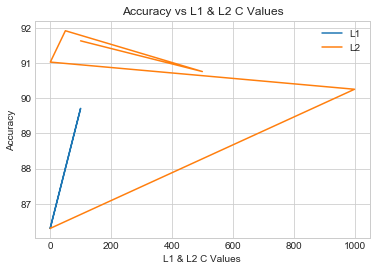

In [45]:
l1_vs_l2_accuracy_plot(a2)

In [46]:
print('Best Hyperparameter and Regularizer ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Hyperparameter and Regularizer  {'penalty': 'l2', 'C': 50}
Best Accuracy 91.913143%


In [47]:
lr_optimal = LogisticRegression(C = a2.best_params_.get('C'),penalty = a2.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [48]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,92.666667,0.945854,0.970901,0.958214


True Positive 37837
True Negative 3863
False Positive 2166
False Negative 1134


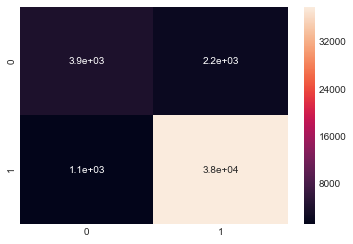

In [49]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [50]:
top_25_features(lr_optimal,count_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,10.049027,sooth,-20.116442,worst
1,10.064277,supris,-15.312181,unbalanc
2,10.131203,inhal,-13.841480,yike
3,10.193276,siberian,-13.598330,mediocr
4,10.237672,mmmmm,-13.359020,undrink
5,10.293607,addict,-13.278857,disastr
6,10.431358,ramun,-12.941103,unpleas
7,10.471546,drawback,-12.749238,allegro
8,10.568587,divin,-12.736742,unaccept
9,10.692870,australian,-12.512670,reagan


### Trigram -LR

### Best Hyperparameter C and Regularizer using GridSearchCV

In [51]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [52]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [53]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search = GridSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  8.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [54]:
save_data(grid_search,'trigram_grid_search_lr')

In [55]:
a1 = load_data('trigram_grid_search_lr')

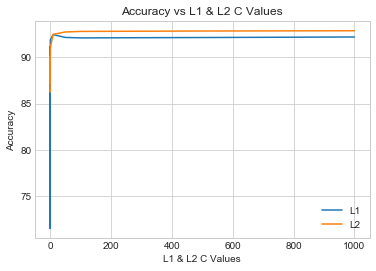

In [56]:
l1_vs_l2_accuracy_plot(a1)

In [57]:
print('Best Hyperparameter and Regularizer ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Hyperparameter and Regularizer  {'C': 1000, 'penalty': 'l2'}
Best Accuracy 92.853714%


In [58]:
lr_optimal = LogisticRegression(C = a1.best_params_.get('C'),penalty = a1.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [59]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,93.62,0.950957,0.976701,0.963657


True Positive 38063
True Negative 4066
False Positive 1963
False Negative 908


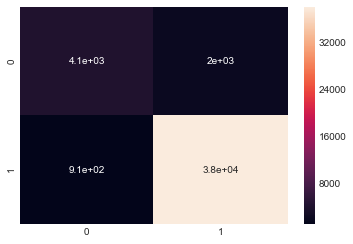

In [60]:
confusion_matrix_plot(y_test,pred)

### Sparsity Analysis

In [61]:
sparsity_analysis(x_train,y_train)

No. of zero elements for C = 0.005 is 4368129
No. of zero elements for C = 0.010 is 4368121
No. of zero elements for C = 0.500 is 4367450
No. of zero elements for C = 0.100 is 4367946
No. of zero elements for C = 1.000 is 4366958
No. of zero elements for C = 10.000 is 4356023
No. of zero elements for C = 50.000 is 4348694
No. of zero elements for C = 100.000 is 4346988
No. of zero elements for C = 500.000 is 4342050
No. of zero elements for C = 1000.000 is 4337325
Percentage increase in Sparsity is 0.71%


### Perturbation Test

In [62]:
no_of_features = multicollinearity_check(x_train,y_train,x_test,y_test,a1.best_params_.get('C'),a1.best_params_.get('penalty'))

Accuracy before adding noise is  93.62
Accuracy after adding noise is  93.64222222222223


In [63]:
print('The number of features with weight changes greater than 70 percent is %d' %(no_of_features))
print('Hence the features are Multicollinear')

The number of features with weight changes greater than 70 percent is 345868
Hence the features are Multicollinear


### Best Hyperparameter C and Regularizer using Randomized SearchCV

In [64]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [65]:
ngram_vect = CountVectorizer(ngram_range=(1,3))
x_train = ngram_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = ngram_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [66]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search_rscv = RandomizedSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search_rscv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [67]:
save_data(grid_search_rscv,'trigram_grid_search_lr_rscv')

In [68]:
a2 = load_data('trigram_grid_search_lr_rscv')

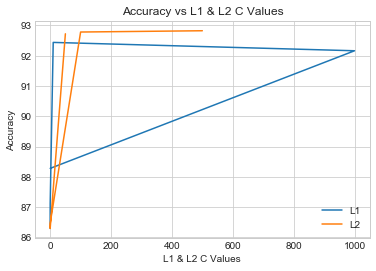

In [69]:
l1_vs_l2_accuracy_plot(a2)

In [70]:
print('Best Hyperparameter and Regularizer ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Hyperparameter and Regularizer  {'penalty': 'l2', 'C': 500}
Best Accuracy 92.822857%


In [71]:
lr_optimal = LogisticRegression(C = a2.best_params_.get('C'),penalty = a2.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [72]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,93.608889,0.950861,0.976675,0.963595


True Positive 38062
True Negative 4062
False Positive 1967
False Negative 909


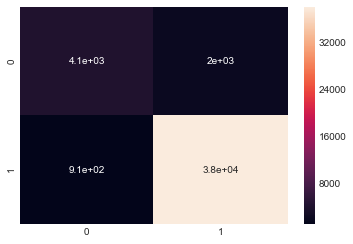

In [73]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [74]:
top_25_features(lr_optimal,ngram_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,14.592840,complaint,-39.394454,worst
1,14.943186,refresh,-28.108482,terribl
2,14.951902,right amount,-28.028916,horribl
3,14.991427,cant wrong,-27.394505,disappoint
4,15.146461,beauti,-27.066069,two star
5,15.579053,nice,-26.410978,aw
6,15.585458,worri,-24.560256,threw
7,15.601378,skeptic,-24.358896,wont buy
8,16.366628,great,-22.749579,disgust
9,16.740456,uniqu,-22.066580,unpleas


### Tf-Idf LR

### Best Hyperparameter C and Regularizer using GridSearchCV

In [75]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [76]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [77]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search = GridSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  2.7min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [78]:
save_data(grid_search,'tfidf_grid_search_lr')

In [79]:
a1 = load_data('tfidf_grid_search_lr')

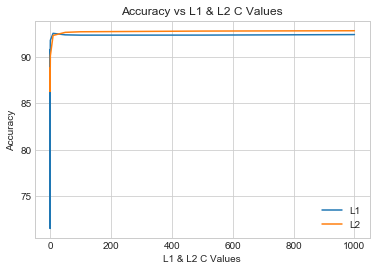

In [80]:
l1_vs_l2_accuracy_plot(a1)

In [81]:
print('Best Hyperparameter and Regularizer ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Hyperparameter and Regularizer  {'C': 1000, 'penalty': 'l2'}
Best Accuracy 92.804571%


In [82]:
lr_optimal = LogisticRegression(C = a1.best_params_.get('C'),penalty = a1.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [83]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,93.782222,0.950552,0.979138,0.964633


True Positive 38158
True Negative 4044
False Positive 1985
False Negative 813


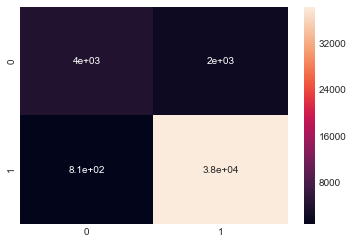

In [84]:
confusion_matrix_plot(y_test,pred)

### Sparsity Analysis

In [85]:
sparsity_analysis(x_train,y_train)

No. of zero elements for C = 0.005 is 1286254
No. of zero elements for C = 0.010 is 1286252
No. of zero elements for C = 0.500 is 1285577
No. of zero elements for C = 0.100 is 1286112
No. of zero elements for C = 1.000 is 1284988
No. of zero elements for C = 10.000 is 1271893
No. of zero elements for C = 50.000 is 1266961
No. of zero elements for C = 100.000 is 1265927
No. of zero elements for C = 500.000 is 1261583
No. of zero elements for C = 1000.000 is 1257971
Percentage increase in Sparsity is 2.25%


### Perturbation Test

In [86]:
no_of_features = multicollinearity_check(x_train,y_train,x_test,y_test,a1.best_params_.get('C'),a1.best_params_.get('penalty'))

Accuracy before adding noise is  93.78222222222222
Accuracy after adding noise is  93.77111111111111


In [87]:
print('The number of features with weight changes greater than 70 percent is %d' %(no_of_features))
print('Hence the features are Multicollinear')

The number of features with weight changes greater than 70 percent is 54842
Hence the features are Multicollinear


### Best Hyperparameter C and Regularizer using Randomized SearchCV

In [88]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, random_state=0)
x_test.head()

226019    found soup spici tast also even allow soup ste...
18104     make lot babi food make meat babi food buy dif...
52352     get past sort fals advertis form torii gate im...
324221    potato crocket shape ball rather gratin nevert...
145649    flax pumpkin seed granola yummi eat four time ...
Name: Cleaned_Text, dtype: object

In [89]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)
normal_scale = Normalizer().fit(x_train)
x_train = normal_scale.transform(x_train)
x_test = tf_idf_vect.transform(x_test)
x_test = normal_scale.transform(x_test)

In [90]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search_rscv = RandomizedSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search_rscv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [91]:
save_data(grid_search_rscv,'tfidf_grid_search_lr_rscv')

In [92]:
a2 = load_data('tfidf_grid_search_lr_rscv')

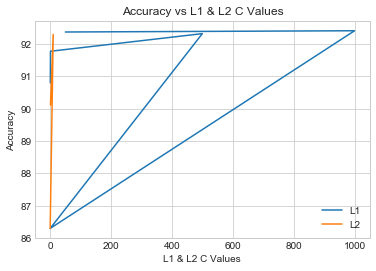

In [93]:
l1_vs_l2_accuracy_plot(a2)

In [95]:
print('Best Hyperparameter and Regularizer ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Hyperparameter and Regularizer  {'penalty': 'l1', 'C': 1000}
Best Accuracy 92.409143%


In [94]:
lr_optimal = LogisticRegression(C = a2.best_params_.get('C'),penalty = a2.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [96]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,93.011111,0.950891,0.969362,0.960038


True Positive 37777
True Negative 4078
False Positive 1951
False Negative 1194


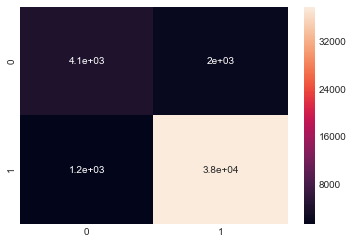

In [97]:
confusion_matrix_plot(y_test,pred)

### Top 25 Important Features for both Positive and Negative Class

In [98]:
top_25_features(lr_optimal,tf_idf_vect)

,Positive Values,Positive Words,Negative Values,Negative Words
0,58.002091,heavili process,-156.580995,two star
1,58.311737,illi brand,-88.630432,complet disappoint
2,58.923298,skeptic,-87.977915,theyr theyr
3,59.380951,excel,-82.035341,worst
4,59.683445,mmmmm,-81.511947,fell short
5,60.328891,downsid,-80.845679,keep stapl
6,60.899453,love,-80.703994,well person
7,61.448377,amaz,-80.548032,rise problem
8,63.138501,box upon,-78.222875,disastr
9,63.227436,perfect,-78.171739,ruse


### Word2Vec LR

### Best Hyperparameter C and Regularizer using GridSearchCV

In [247]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'] ,lr_data['Score'], test_size=0.3, shuffle = False)

In [248]:
list_of_train_sent = []
for sent in x_train.values:
    list_of_train_sent.append(sent.split())

In [249]:
len(list_of_train_sent)

105000

In [250]:
w2v_model = Word2Vec(list_of_train_sent,min_count=5,workers=4,size=100)

In [251]:
w2v_words = list(w2v_model.wv.vocab)

In [252]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [253]:
sent_vectors_arr = np.asarray(sent_vectors)

In [254]:
x_train = normalize(sent_vectors_arr)

In [255]:
list_of_test_sent = []
for sent in x_test.values:
    list_of_test_sent.append(sent.split())

len(list_of_test_sent)

45000

In [256]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            #print(sent_vec)
            cnt_words += 1
            #print(cnt_words)
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

In [257]:
sent_vectors_arr = np.asarray(sent_vectors)
x_test = normalize(sent_vectors_arr)

In [258]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search = GridSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  2.2min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [259]:
save_data(grid_search,'w2v_grid_search_lr')

In [260]:
a1 = load_data('w2v_grid_search_lr') 

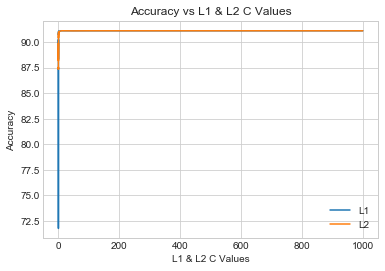

In [261]:
l1_vs_l2_accuracy_plot(a1)

In [262]:
print('Best Hyperparameter and Regularizer ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Hyperparameter and Regularizer  {'C': 10, 'penalty': 'l2'}
Best Accuracy 91.091429%


In [263]:
lr_optimal = LogisticRegression(C = a1.best_params_.get('C'),penalty = a1.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [264]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.171111,0.906864,0.969725,0.937242


True Positive 36387
True Negative 3740
False Positive 3737
False Negative 1136


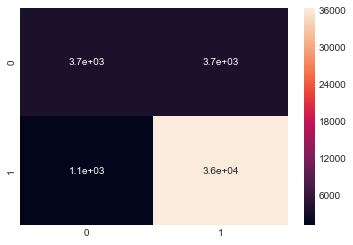

In [265]:
confusion_matrix_plot(y_test,pred)

### Sparsity Analysis

In [266]:
sparsity_analysis(x_train,y_train)

No. of zero elements for C = 0.005 is 81
No. of zero elements for C = 0.010 is 72
No. of zero elements for C = 0.500 is 5
No. of zero elements for C = 0.100 is 19
No. of zero elements for C = 1.000 is 3
No. of zero elements for C = 10.000 is 1
No. of zero elements for C = 50.000 is 0
No. of zero elements for C = 100.000 is 0
No. of zero elements for C = 500.000 is 0
No. of zero elements for C = 1000.000 is 0
Percentage increase in Sparsity is 100.00%


### Perturbation Test

In [267]:
no_of_features = multicollinearity_check(x_train,y_train,x_test,y_test,a1.best_params_.get('C'),a1.best_params_.get('penalty'))

Accuracy before adding noise is  89.17111111111112
Accuracy after adding noise is  89.13333333333333


In [268]:
print('The number of features with weight changes greater than 70 percent is %d' %(no_of_features))
print('Hence the features are Multicollinear')

The number of features with weight changes greater than 70 percent is 2
Hence the features are Multicollinear


### Best Hyperparameter C and Regularizer using Randomized SearchCV

In [269]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search_rscv = RandomizedSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search_rscv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   35.4s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [270]:
save_data(grid_search_rscv,'w2v_grid_search_lr_rscv')

In [271]:
a2 = load_data('w2v_grid_search_lr_rscv') 

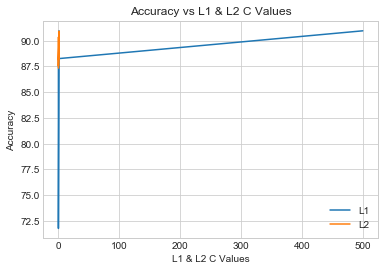

In [272]:
l1_vs_l2_accuracy_plot(a2)

In [273]:
print('Best Hyperparameter and Regularizer ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Hyperparameter and Regularizer  {'penalty': 'l1', 'C': 1}
Best Accuracy 90.962286%


In [274]:
lr_optimal = LogisticRegression(C = a2.best_params_.get('C'),penalty = a2.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [275]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.128889,0.905646,0.970765,0.937076


True Positive 36426
True Negative 3682
False Positive 3795
False Negative 1097


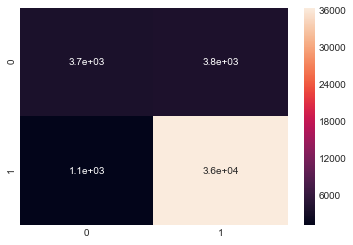

In [276]:
confusion_matrix_plot(y_test,pred)

### Tf-Idf Word2Vec LR

In [277]:
x_train, x_test, y_train, y_test = train_test_split(lr_data['Cleaned_Text'].head(20000) ,lr_data['Score'].head(20000), test_size=0.3, random_state=0)
x_test.head()

463606    caramel best tast like one sugar especi like e...
414696    husband love salt also love product product li...
360045    best gluten free granola great flavor tast lik...
389146    ive done lot research one best natur dog food ...
300971    seawe msg free seawe great product one nice sp...
Name: Cleaned_Text, dtype: object

In [278]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
x_train = tf_idf_vect.fit_transform(x_train)

In [279]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in list_of_train_sent: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_train[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    if row == (x_train.shape[0]):
        break

In [280]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_train = normalize(tfidf_sent_vectors_arr)
x_test = tf_idf_vect.transform(x_test)

In [281]:
save_data(x_train,'tfidf_w2v_train_set')

In [284]:
tfidf_feat= tf_idf_vect.get_feature_names()
tfidf_sent_vectors = []
row=0;
for sent in list_of_test_sent: # for each review/sentence 
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if ((word in w2v_words) and (word in tfidf_feat)):
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = x_test[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
    row += 1
    if row == (x_test.shape[0]):
        break

In [285]:
tfidf_sent_vectors_arr = np.asarray(tfidf_sent_vectors)
x_test = normalize(tfidf_sent_vectors_arr)

In [286]:
save_data(x_test,'tfidf_w2v_test_set')

In [297]:
y_train = y_train.head(x_train.shape[0])
y_test = y_test.head(x_test.shape[0])

In [298]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search = GridSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    5.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [299]:
save_data(grid_search,'tfidf_w2v_grid_search_lr')

In [300]:
a1 = load_data('tfidf_w2v_grid_search_lr') 

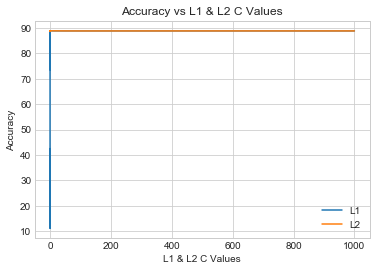

In [301]:
l1_vs_l2_accuracy_plot(a1)

In [302]:
print('Best Hyperparameter and Regularizer ',a1.best_params_)
print('Best Accuracy %f% %'%(a1.best_score_*100))

Best Hyperparameter and Regularizer  {'C': 0.0005, 'penalty': 'l2'}
Best Accuracy 88.965517%


In [303]:
lr_optimal = LogisticRegression(C = a1.best_params_.get('C'),penalty = a1.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [304]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.505722,0.895057,1.0,0.944623


True Positive 3676
True Negative 0
False Positive 431
False Negative 0


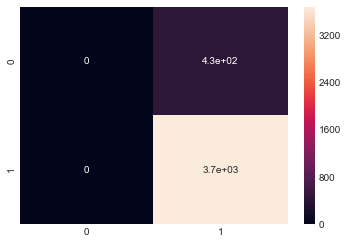

In [305]:
confusion_matrix_plot(y_test,pred)

### Sparsity Analysis

In [306]:
sparsity_analysis(x_train,y_train)

No. of zero elements for C = 0.005 is 100
No. of zero elements for C = 0.010 is 100
No. of zero elements for C = 0.500 is 74
No. of zero elements for C = 0.100 is 100
No. of zero elements for C = 1.000 is 45
No. of zero elements for C = 10.000 is 9
No. of zero elements for C = 50.000 is 3
No. of zero elements for C = 100.000 is 1
No. of zero elements for C = 500.000 is 0
No. of zero elements for C = 1000.000 is 0
Percentage increase in Sparsity is 100.00%


### Perturbation Test

In [307]:
no_of_features = multicollinearity_check(x_train,y_train,x_test,y_test,a1.best_params_.get('C'),a1.best_params_.get('penalty'))

Accuracy before adding noise is  89.50572193815437
Accuracy after adding noise is  89.50572193815437


In [309]:
print('The number of features with weight changes greater than 70 percent is %d' %(no_of_features))
print('Hence the features are not Multicollinear')

The number of features with weight changes greater than 70 percent is 0
Hence the features are not Multicollinear


### Best Hyperparameter C and Regularizer using Randomized SearchCV

In [321]:
lr = LogisticRegression()
time_split_cv = TimeSeriesSplit(n_splits = 5)
C_list = [0.0005,0.0001,0.005,0.001,0.05,0.01,0.5,0.1,1,10,50,100,500,1000]
param_grid = {'C':C_list,'penalty':['l1','l2']}
grid_search_rscv = RandomizedSearchCV(lr,param_grid,cv=time_split_cv,verbose=1,n_jobs=-1)
grid_search_rscv.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.0s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [0.0005, 0.0001, 0.005, 0.001, 0.05, 0.01, 0.5, 0.1, 1, 10, 50, 100, 500, 1000], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=1)

In [322]:
save_data(grid_search_rscv,'tfidf_w2v_grid_search_lr_rscv')

In [323]:
a2 = load_data('tfidf_w2v_grid_search_lr_rscv') 

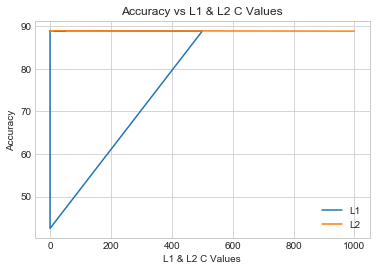

In [324]:
l1_vs_l2_accuracy_plot(a2)

In [325]:
print('Best Hyperparameter and Regularizer ',a2.best_params_)
print('Best Accuracy %f% %'%(a2.best_score_*100))

Best Hyperparameter and Regularizer  {'penalty': 'l1', 'C': 0.005}
Best Accuracy 88.965517%


In [326]:
lr_optimal = LogisticRegression(C = a2.best_params_.get('C'),penalty = a2.best_params_.get('penalty'))
lr_optimal.fit(x_train, y_train)
pred = lr_optimal.predict(x_test)
acc = accuracy_score(y_test, pred) * 100

In [327]:
metric_scores(y_test,pred)

,Accuracy,Precision score,Recall score,F1 score
0,89.505722,0.895057,1.0,0.944623


True Positive 3676
True Negative 0
False Positive 431
False Negative 0


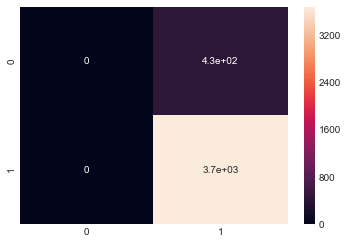

In [328]:
confusion_matrix_plot(y_test,pred)

### Summary

In [329]:
summary_of_scores()

+--------------+-------------------+--------+--------------+-------------------+
|    Model     |     CV - Type     | Best C | Best Penalty |   Best Accuracy   |
+--------------+-------------------+--------+--------------+-------------------+
|     BOW      |    Grid Search    |   10   |      l2      | 92.26514285714286 |
|     BOW      | Randomized Search |   50   |      l2      | 91.91314285714286 |
|   Trigram    |    Grid Search    |  1000  |      l2      | 92.85371428571429 |
|   Trigram    | Randomized Search |  500   |      l2      | 92.82285714285715 |
|    Tf-Idf    |    Grid Search    |  1000  |      l2      | 92.80457142857142 |
|    Tf-Idf    | Randomized Search |  1000  |      l1      | 92.40914285714285 |
|     W2V      |    Grid Search    |   10   |      l2      | 91.09142857142857 |
|     W2V      | Randomized Search |   1    |      l1      | 90.96228571428571 |
| Tf-Idf - W2v |    Grid Search    | 0.0005 |      l2      | 88.96551724137932 |
| Tf-Idf - W2v | Randomized 